# Interactive Molecule Parameters — Temperature, Column Density, Radius

This notebook attaches sliders for the key physical parameters of a single molecule. When a slider changes, we update the `Molecule` object directly — its internal caching automatically triggers the necessary recalculations — then refresh the plot.

This is the notebook equivalent of the iSLAT GUI parameter panel.

In [13]:
# First, add the iSLAT package to the Python path
import sys
from pathlib import Path

# Navigate from notebook location to the iSLATTests directory (where iSLAT package lives)
notebook_dir = Path.cwd()
islat_root = notebook_dir.parent.parent.parent  # Interactive Widgets -> Notebooks -> Examples -> iSLAT
if str(islat_root) not in sys.path:
    sys.path.insert(0, str(islat_root))

# Core libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Use the interactive widget backend for matplotlib
%matplotlib widget

# IPython widget libraries
import ipywidgets as widgets
from IPython.display import display, clear_output

# iSLAT data types
from iSLAT.Modules.DataTypes import Molecule, MoleculeDict

# iSLAT standalone plot classes
from iSLAT.Modules.Plotting import (
    BasePlot,
    DEFAULT_THEME,
    LineInspectionPlot,
    PopulationDiagramPlot,
    FullSpectrumPlot,
    MainPlotGrid,
)

print("Imports successful!")
print(f"matplotlib backend: {matplotlib.get_backend()}")

Imports successful!
matplotlib backend: widget


In [14]:
# --- Load observed data and define a molecule factory ---
import pandas as pd

# Load CI Tau MIRI spectrum (Banzatti+2023b)
data_path = Path(islat_root) / "iSLAT" / "DATAFILES" / "EXAMPLE-data" / "CITau_MIRI_Banzatti+2023b.csv"
obs = pd.read_csv(data_path)

wave_grid     = obs["wave"].values
observed_flux = obs["flux"].values
observed_err  = obs["err"].values
continuum     = obs["cont"].values

print(f"Loaded: {data_path.name}")
print(f"  {len(wave_grid)} points, {wave_grid.min():.2f}–{wave_grid.max():.2f} μm")

# Paths to HITRAN parameter files
data_dir = Path(islat_root) / "iSLAT" / "DATAFILES" / "HITRANdata"
water_par_file = str(data_dir / "data_Hitran_H2O.par")
co_par_file    = str(data_dir / "data_Hitran_CO.par")
co2_par_file   = str(data_dir / "data_Hitran_CO2.par")

# Wavelength range derived from observed data
wavelength_range = (float(wave_grid.min()), float(wave_grid.max()))

# Default molecule definitions (shared across all sections)
DEFAULT_MOLECULES = {
    "H2O": {"Molecule Name": "H2O", "temp": 850, "n_mol": 1e18, "radius": 0.5, "color": "#0000FF",
             "displaylabel": "$H_2O$", "File Path": water_par_file},
    "CO":  {"Molecule Name": "CO",  "temp": 1000, "n_mol": 1e18, "radius": 0.4, "color": "#FF0000",
             "displaylabel": "CO",  "File Path": co_par_file},
    "CO2": {"Molecule Name": "CO2", "temp": 300,  "n_mol": 1e17, "radius": 0.5, "color": "green",
             "displaylabel": "$CO_2$", "File Path": co2_par_file},
}

def create_mol_dict():
    """
    Create a fresh, independent MoleculeDict with the default molecules.
    """
    md = MoleculeDict(
        global_distance=160,
        global_stellar_rv=0.0,
        global_wavelength_range=wavelength_range,
        global_model_pixel_res=0.0013,
    )
    md.load_molecules(
        molecules_data=[v for v in DEFAULT_MOLECULES.values()],
        initial_molecule_parameters=DEFAULT_MOLECULES,
    )
    md.bulk_update_parameters({"fwhm": 130, "broad": 1})
    return md

# Quick sanity check
_test = create_mol_dict()
print(f"create_mol_dict() → {list(_test.keys())}")
del _test

Loaded: CITau_MIRI_Banzatti+2023b.csv
  10672 points, 4.90–28.72 μm
Deferring intensity calculations for 3 molecules
create_mol_dict() → ['H2O', 'CO', 'CO2']


Deferring intensity calculations for 3 molecules
Calculating intensity for H2O: T=850.0K, N_mol=1.00e+18, dv=1.0


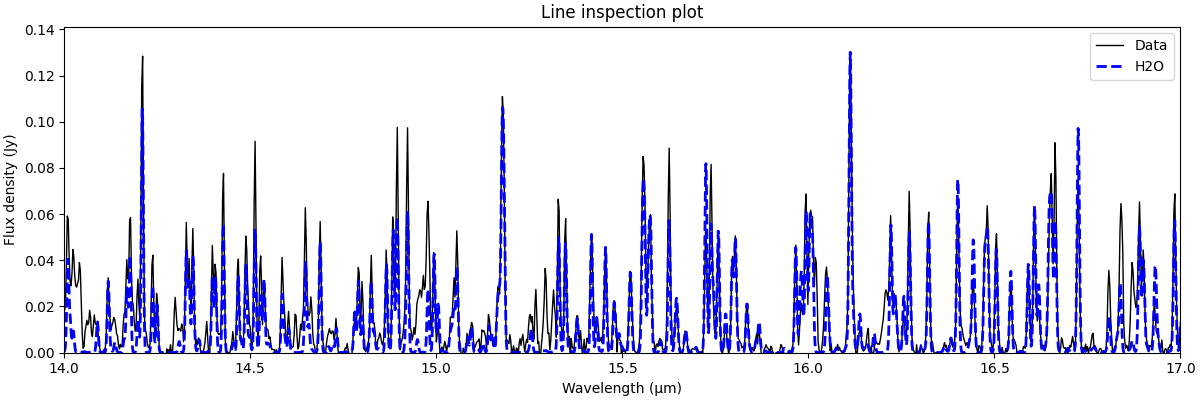

In [15]:
# --- Interactive parameter sliders for a single molecule (H2O) ---

update_continuously = True  # Set to False for faster updates when dragging sliders

mol_dict_2 = create_mol_dict()
mol = mol_dict_2["H2O"]

# Create the plot showing the H2O model in a narrow window
param_lip = LineInspectionPlot(
    wave_data=wave_grid,
    flux_data=observed_flux,
    xmin=14.0,
    xmax=17.0,
    molecule=mol,
    figsize=(12, 4),
)
param_lip.generate_plot()

# --- Build parameter sliders ---
temp_slider = widgets.IntSlider(
    value=int(mol.temp), min=100, max=2000, step=50,
    description='T (K):', continuous_update=update_continuously,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
)

# Column density uses a log scale: slider value is the exponent
import math
log_n_init = math.log10(mol.n_mol)
log_n_slider = widgets.FloatSlider(
    value=log_n_init, min=14, max=22, step=0.1,
    description='log₁₀ N (cm⁻²):', continuous_update=update_continuously,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
    readout_format='.1f',
)

radius_slider = widgets.FloatSlider(
    value=mol.radius, min=0.05, max=5.0, step=0.05,
    description='Radius (AU):', continuous_update=update_continuously,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
)

# Label showing current parameter values
info_label = widgets.HTML(
    value=f"<b>{mol.displaylabel}</b> — T={mol.temp:.0f} K, "
          f"N={mol.n_mol:.1e} cm^-2, R={mol.radius:.2f} AU"
)

def update_molecule_params(change):
    """Update the molecule and regenerate the plot."""
    mol.temp = float(temp_slider.value)
    mol.n_mol = 10 ** log_n_slider.value
    mol.radius = radius_slider.value

    # Update info label
    info_label.value = (
        f"<b>{mol.displaylabel}</b> — T={mol.temp:.0f} K, "
        f"N={mol.n_mol:.1e} cm^-2, R={mol.radius:.2f} AU"
    )

    # Regenerate and redraw
    param_lip.generate_plot()
    param_lip.fig.canvas.draw_idle()

temp_slider.observe(update_molecule_params, names='value')
log_n_slider.observe(update_molecule_params, names='value')
radius_slider.observe(update_molecule_params, names='value')

# Layout: sliders stacked vertically, then the plot
controls = widgets.VBox([info_label, temp_slider, log_n_slider, radius_slider])
display(controls)
param_lip.show()